Import

In [1]:
import os

import numpy as np
import pandas as pd
import pydicom as dicom
import ast
from glob import glob

import matplotlib.pyplot as plt
import matplotlib

import warnings
import tqdm
warnings.filterwarnings('ignore')

PATH

In [2]:
SAMP_SUB = '../input/siim-covid19-detection/sample_submission.csv'
TRAIN_IMAGE_LEVEL = '../input/siim-covid19-detection/train_image_level.csv'
TRAIN_STUDY_LEVEL = '../input/siim-covid19-detection/train_study_level.csv'
TRAIN_PATH = '../input/siim-covid19-detection/train'
TEST_PATH = '../input/siim-covid19-detection/test'

In [3]:
samp_sub = pd.read_csv(SAMP_SUB)
print('samp_sub')
display(samp_sub.head())

train_image_level = pd.read_csv(TRAIN_IMAGE_LEVEL)
print('train_image_level')
display(train_image_level.head())

train_study_level = pd.read_csv(TRAIN_STUDY_LEVEL)
print('train_study_level')
display(train_study_level.head())


samp_sub


,id,PredictionString
0,00188a671292_study,negative 1 0 0 1 1
1,004bd59708be_study,negative 1 0 0 1 1
2,00508faccd39_study,negative 1 0 0 1 1
3,006486aa80b2_study,negative 1 0 0 1 1
4,00655178fdfc_study,negative 1 0 0 1 1


train_image_level


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


train_study_level


,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [4]:
# def train_image_info(id):
#     path = f'../input/siim-covid19-detection/train/{str(id)}'
#     for r, d, f in os.walk(path):
#         for n in f:
#             path = os.path.join(r, n)
#     print(path)
#     dc = dicom.dcmread(path)
#     plt.imshow(sample_dicom, cmap='Greys')
#     plt.show()
    
    
# train_image_info('000a312787f2')

In [5]:
train_image_level.sort_values(['StudyInstanceUID'], 0)
display(train_image_level.head())
train_study_level.sort_values(['id'])
display(train_study_level)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


In [6]:
train_study_level['id'] = train_study_level['id'].str.split('_', expand=True)
train_study_level = train_study_level.rename({'id': 'StudyInstanceUID'}, axis=1)
train_df = pd.merge(train_image_level, train_study_level, on='StudyInstanceUID')
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0


In [7]:
dc_path = '../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm' 
dc = dicom.dcmread(dc_path).pixel_array

In [8]:
boxes = ast.literal_eval(train_df.loc[0, 'boxes'])
boxes

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

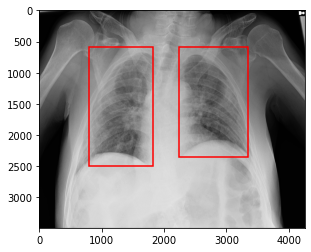

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                      box['width'], box['height'],
                                      ec='r', fc='none', lw=1.5)
    ax.add_patch(p)
ax.imshow(dc, cmap='gray')
plt.show()

In [10]:
train_df.loc[0, 'label']

'opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472'

In [11]:
train_df['OpacityCount'] = train_df['label'].str.count('opacity').values
train_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2


In [12]:
train_df['Opacity'] = train_df['OpacityCount'].apply(lambda c: 1 if c > 0 else 0)

In [13]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1


In [14]:
type_df = pd.DataFrame(train_df.groupby(list(train_df.columns[4:8]))['StudyInstanceUID'].count()).reset_index()
# train_df.groupby('Negative for Pneumonia')['StudyInstanceUID'].count()
type_df

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,StudyInstanceUID
0,0,0,0,1,483
1,0,0,1,0,1108
2,0,1,0,0,3007
3,1,0,0,0,1736


In [15]:
type_df['StudyInstanceUID'].sum()

6334

In [16]:
path_list = []
for i, row in train_df.iterrows():
    image_id = row['id'].split('_')[0]
    study_id = row['StudyInstanceUID']
    image_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/{image_id}.dcm')
    if len(image_path) == 1:
        path_list.append(image_path[0])
    else:
        print(image_path)

In [17]:
len(path_list)

6334

In [18]:
train_df['Path'] = path_list
train_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...
...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0,0,../input/siim-covid19-detection/train/7e6c6846...
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0,0,../input/siim-covid19-detection/train/8332bdad...
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3,1,../input/siim-covid19-detection/train/7eed9af0...
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2,1,../input/siim-covid19-detection/train/a0cb0b96...


In [ ]:
# PatientSex

In [34]:
dicom_samp = dicom.dcmread(train_df['Path'].iloc[0])

SyntaxError: invalid token (<ipython-input-34-f48874d36fbd>, line 1)

In [31]:
dicom_samp

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.135099524260102611886915167296699866712
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 000a312787f2
(0008, 0020) Study Date                          DA: '526316e376d4'
(0008, 0030) Study Time                          TM: '8ccfb6acf07f'
(0008, 0050) Accession Number                    SH: 'f6cd7f2019f5'
(0008, 0060) Modality                            CS: 'DX'
(0010, 0010) Patient's Name                      PN: 'd4268f26ed05'
(

In [35]:
patient_sex_list = []
for i in path_list:
    patient_sex_list.append(dicom.dcmread(i, stop_before_pixels=True).PatientSex)

In [37]:
train_df['PatientSex'] = patient_sex_list

In [38]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,PatientSex
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,M
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,M
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,F
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,F
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,M


In [47]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['PatientSex'], prefix='Sex')], axis=1)

In [51]:
train_df = train_df.drop('PatientSex', 1)

In [52]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,Sex_F,Sex_M
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,0,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,0,1
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,1,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,1,0
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,0,1


In [54]:
train_df.to_csv('train_df.csv', index=False)